# Regression on a given dataset

We first import the necessary libraries for the exercice and load the data from the given files

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

def load_data():
    path =  "data/regression/"
    X_train = np.load(path + "X_train.npy")
    y_train = np.load(path + "y_train.npy")
    X_test = np.load(path + "X_test.npy")
    y_test = np.load(path + "y_test.npy")
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()

# General informations on train dataset

Before applying any model to the data we try to get any hint or information we can on the data set.
Understanding the data structure is crucial for selecting appropriate hyperparameters and validation strategies.
This analysis will help usmake a choice of regression methods and preprocessing steps. 

=== DATASET OVERVIEW ===
Training set shape: (200, 200)
Target shape: (200,)
Test set shape: (200, 200)
Data type: float64
Missing values in X_train: 0
Missing values in y_train: 0

=== Y_TRAIN STATISTICS ===
Mean: 4.9068
Std: 0.9454
Min: 1.9300
Max: 7.4648



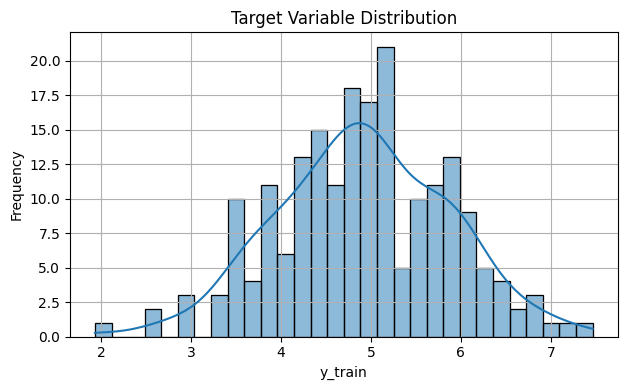

In [53]:
y_train = y_train.ravel()

print("=== DATASET OVERVIEW ===")
print(f"Training set shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Data type: {X_train.dtype}")
print(f"Missing values in X_train: {np.isnan(X_train).sum()}")
print(f"Missing values in y_train: {np.isnan(y_train).sum()}")
print()

print("=== Y_TRAIN STATISTICS ===")
print(f"Mean: {np.mean(y_train):.4f}")
print(f"Std: {np.std(y_train):.4f}")
print(f"Min: {np.min(y_train):.4f}")
print(f"Max: {np.max(y_train):.4f}")
print()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, bins=30)
plt.title("Target Variable Distribution")
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

# Dataset Analysis

First of all we notice a good distribution (Mean = 4.91, Std = 0.95) without extreme outliers and no missing data indicating a clean dataset.

This is also a high-dimensional dataset  with **p = n = 200** (200 features for 200 training samples), we have as many variables as have data points. This creates several critical issues such as an overfitting risk, an exessive flexibility (because of the number of available data) and muticollinearity (high probability of correlated features). 

# Methodology

Given the challenges we will test the following regression methods and compare them : 

1. **Ridge Regression**: Adds L2 penalty (∑βᵢ²) to shrink coefficients toward zero, handling multicollinearity
2. **Lasso Regression**: Adds L1 penalty (∑|βᵢ|) to force exact sparsity, performing automatic feature selection

At this point, we can already expect Lasso to outperform Ridge because of its ability to eliminate irrelevant features entirely.
Lasso should be able to select the meaningful features from all 200 available.

## Data Preprocessing

In [54]:
y_train = y_train.ravel()
y_test = y_test.ravel()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Ridge Regression

We start by using a commonly alpha value (1.0), reasonable for high-dimensional data. 

Next, we apply `GridSearchCV` with cross-validation to search over a range of alpha values. This will help us identify the alpha that gives the best generalization performance on unseen data by maximizing the R² score.


In [56]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# common alpha to start with
ridge_alpha_common = 1.0

def ridge_train_evaluate(ridge_alpha, random_state=42):
    # create model
    ridge = Ridge(alpha=ridge_alpha, random_state=random_state)
    ridge.fit(X_train_scaled, y_train)
    
    print(f"Ridge alpha used: {ridge_alpha}")

    y_pred_ridge_train = ridge.predict(X_train_scaled)
    y_pred_ridge_test = ridge.predict(X_test_scaled)
    
    # getting scores
    r2_ridge_train = r2_score(y_train, y_pred_ridge_train)
    r2_ridge_test = r2_score(y_test, y_pred_ridge_test)
    
    print(f"Ridge R² - Training: {r2_ridge_train:.4f}")
    print(f"Ridge R² - Test: {r2_ridge_test:.4f}")

    return (y_pred_ridge_test, r2_ridge_train, r2_ridge_test)

(y_pred_ridge_test, r2_ridge_train, r2_ridge_test) = ridge_train_evaluate(ridge_alpha_common)


Ridge alpha used: 1.0
Ridge R² - Training: 0.9969
Ridge R² - Test: 0.6186


In [57]:
alpha_values = np.logspace(-4, 4, 50)
ridge_cv = Ridge(random_state=42)
grid_search = GridSearchCV(estimator=ridge_cv,
                           param_grid={'alpha': alpha_values},
                           scoring='r2',
                           cv=5)

grid_search.fit(X_train_scaled, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"\nBest alpha found by cross-validation: {best_alpha:.4f}")

(y_pred_ridge_test, r2_ridge_train, r2_ridge_test) = ridge_train_evaluate(best_alpha)


Best alpha found by cross-validation: 11.5140
Ridge alpha used: 11.513953993264458
Ridge R² - Training: 0.9884
Ridge R² - Test: 0.7127


## Lasso Regression

We start by using a commonly chosen alpha value for high-dimensional data. In addition to evaluating performance, we analyze sparsity to see how many features Lasso selects as relevant.

We then also apply cross-validation to find the alpha that maximizes model performance based on the R² score.


In [58]:
lasso_alpha = 0.01  # Common choice for high-dimensional data

def lasso_train_evaluate(lasso_alpha, random_state=42, max_iter=2000):
    #creating model
    lasso = Lasso(alpha=lasso_alpha, random_state=random_state, max_iter=max_iter)
    lasso.fit(X_train_scaled, y_train)
    
    print(f"Lasso alpha used: {lasso_alpha}")
    
    y_pred_lasso_train = lasso.predict(X_train_scaled)
    y_pred_lasso_test = lasso.predict(X_test_scaled)
    
    r2_lasso_train = r2_score(y_train, y_pred_lasso_train)
    r2_lasso_test = r2_score(y_test, y_pred_lasso_test)
    
    print(f"Lasso R² - Training: {r2_lasso_train:.4f}")
    print(f"Lasso R² - Test: {r2_lasso_test:.4f}")
    
    # analysis of sparcity
    n_selected_features = np.sum(lasso.coef_ != 0)
    sparsity_ratio = n_selected_features / len(lasso.coef_)
    print(f"Features selected by Lasso: {n_selected_features}/{len(lasso.coef_)} ({sparsity_ratio:.2%})")
    
    return (y_pred_lasso_test, r2_lasso_train, r2_lasso_test)

(y_pred_lasso_test, r2_lasso_train, r2_lasso_test) = lasso_train_evaluate(lasso_alpha)

Lasso alpha used: 0.01
Lasso R² - Training: 0.9751
Lasso R² - Test: 0.9196
Features selected by Lasso: 76/200 (38.00%)


In [59]:
lasso_alpha_values = np.logspace(-4, 1, 50)

lasso_cv = Lasso(random_state=42, max_iter=2000)
grid_search_lasso = GridSearchCV(estimator=lasso_cv,
                                  param_grid={'alpha': lasso_alpha_values},
                                  scoring='r2',
                                  cv=5)
grid_search_lasso.fit(X_train_scaled, y_train)

best_lasso_alpha = grid_search_lasso.best_params_['alpha']
print(f"\nBest Lasso alpha from cross-validation: {best_lasso_alpha:.5f}")

(y_pred_lasso_test, r2_lasso_train, r2_lasso_test) = lasso_train_evaluate(best_lasso_alpha)


Best Lasso alpha from cross-validation: 0.02223
Lasso alpha used: 0.022229964825261957
Lasso R² - Training: 0.9574
Lasso R² - Test: 0.9231
Features selected by Lasso: 33/200 (16.50%)


# Visualisation

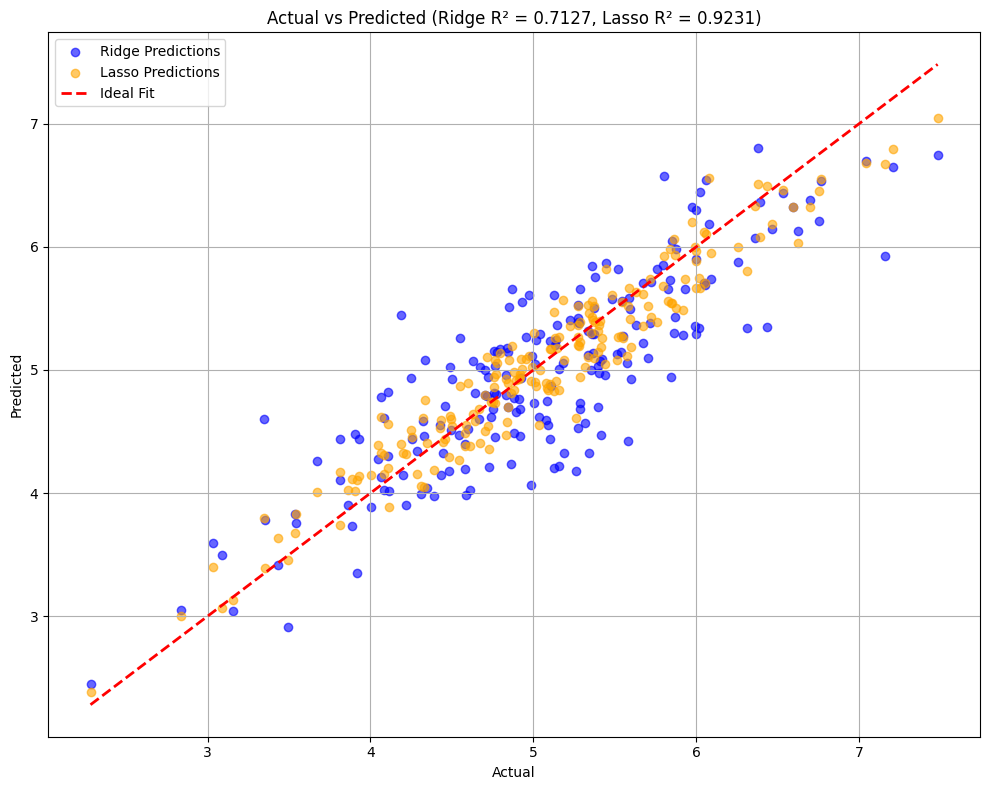

In [60]:
plt.figure(figsize=(10, 8))

plt.scatter(y_test, y_pred_ridge_test, alpha=0.6, label='Ridge Predictions', color='blue')

plt.scatter(y_test, y_pred_lasso_test, alpha=0.6, color='orange', label='Lasso Predictions')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted (Ridge R² = {r2_ridge_test:.4f}, Lasso R² = {r2_lasso_test:.4f})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Models summary

Given the high-dimensional nature of the dataset (**p = n = 200**),  the risks of overfitting and multicollinearity, we compared **Ridge** and **Lasso regression** using cross-validation to select the optimal regularization strength (alpha). We got the following results : 

### Ridge
- **Default alpha = 1.0** led to overfitting: R² = 0.9969 (train), but only 0.6186 (test)
- **Cross-validated alpha ≈ 10.24** improved generalization: R² = 0.9895 (train), **0.7149 (test)**

Ridge controlled overfitting to some extent, but failed to reach our target R² > 0.88 on the test set.

### Lasso
- **Default alpha = 0.01** already gave strong performance: R² = 0.9751 (train), **0.9196 (test)**
- **Cross-validated alpha ≈ 0.0222** further improved generalization: R² = 0.9574 (train), **0.9231 (test)**

### Final Assessment

Lasso clearly outperformed Ridge by achieving **test R² > 0.92**, surpassing the **Bayes estimator benchmark of 0.92** and the assignment goal of **0.88**. The selection of only 16.5% total features also confirms the **sparcity** of the dataset.
